# YOLOv8 牙齿检测 Demo

1. 测试集中单张图片检测效果【真实标签 vs 模型预测】

- 随机抽取测试集中单张图片
- 绿色框 --> 真实标签
- 红色框 --> 模型预测

模型文件路径: outputs\oralxrays9\train_yolov8m_1ep_2025_08_17_21_25_02\weights\best.pt
配置文件路径: preprocessed_datasets/oralxrays9/data.yaml
所有文件存在，准备开始检测！
测试集路径: preprocessed_datasets/oralxrays9\test\images
正在加载模型...
模型加载成功!
类别名称: ['Apical Periodontitis', 'Decay', 'Wisdom Tooth', 'Missing Tooth', 'Dental Filling', 'Root Canal Filling', 'Implant', 'Porcelain Crown', 'Ceramic Bridge']
测试集共有 1614 张图像
随机选择图像: 026215.jpg


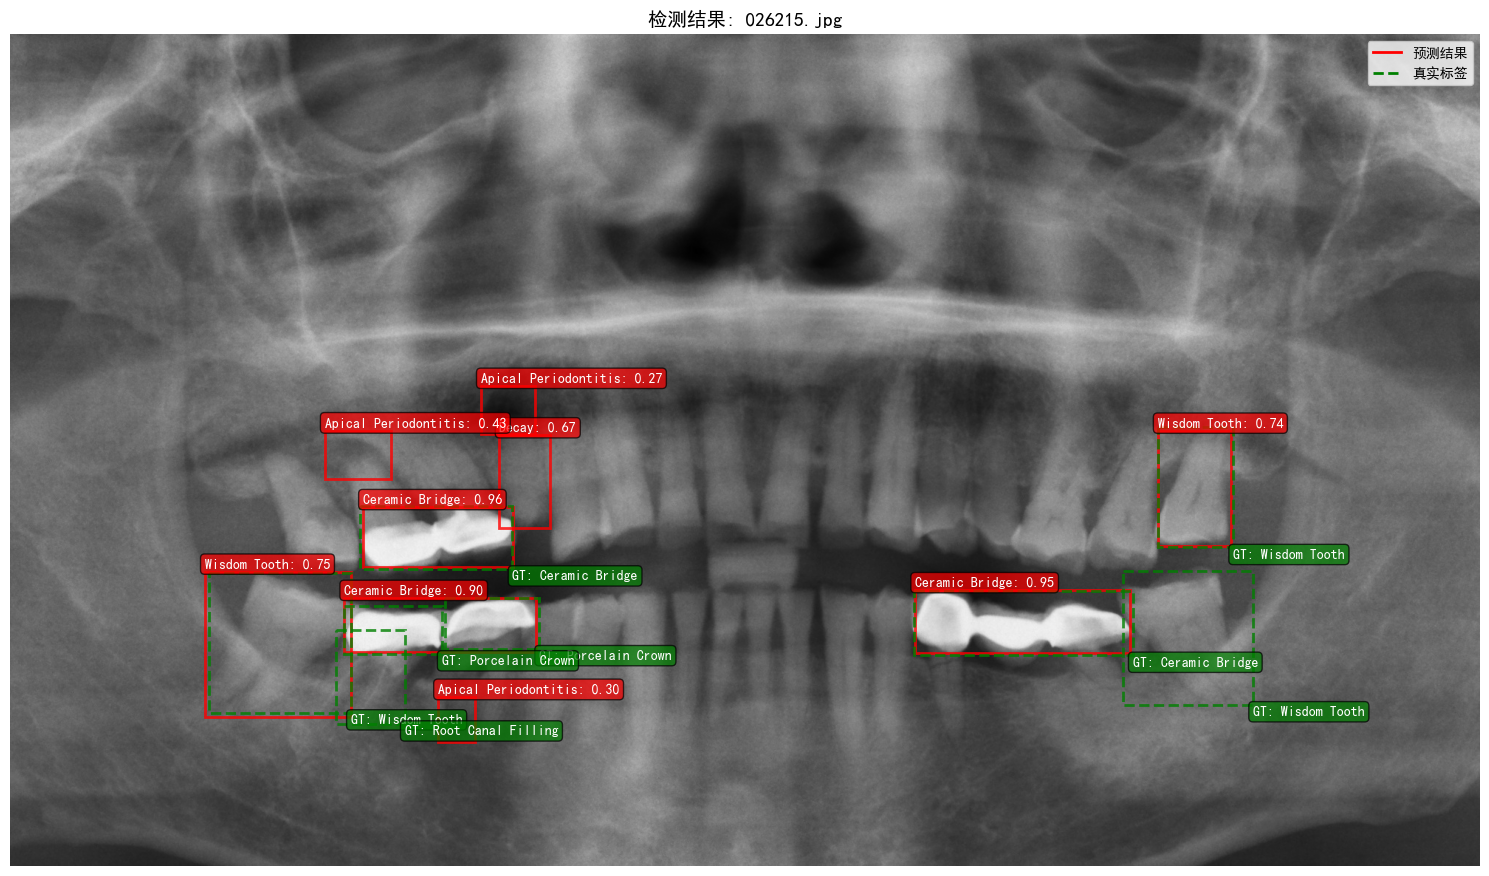

In [15]:
from utils.demo_utils import DentalDetectionDemo
import os
import yaml
import random

# 模型文件路径【手动输入】
model_path = r"outputs\oralxrays9\train_yolov8m_1ep_2025_08_17_21_25_02\weights\best.pt"

# 模型文件路径格式: outputs/{dataset_name}/train_xxx/weights/best.pt
# 对应的data_yaml: preprocessed_datasets/{dataset_name}/data.yaml
path_parts = model_path.replace('\\', '/').split('/')
dataset_name = path_parts[1]
data_yaml = f"preprocessed_datasets/{dataset_name}/data.yaml"

print(f"模型文件路径: {model_path}")
print(f"配置文件路径: {data_yaml}")

# 检查文件存在性
if not os.path.exists(model_path):
    print(f"错误: 模型文件不存在")
    raise FileNotFoundError(f"模型文件不存在: {model_path}")
elif not os.path.exists(data_yaml):
    print(f"错误: 配置文件不存在")
    raise FileNotFoundError(f"配置文件不存在: {data_yaml}")
else:
    print("所有文件存在，准备开始检测！")

# 从data.yaml配置文件中读取测试集路径
with open(data_yaml, 'r', encoding='utf-8') as f:
    data_config = yaml.safe_load(f)

# 获取测试集图像目录路径
test_images_dir = os.path.join(os.path.dirname(data_yaml), "test", "images")
print(f"测试集路径: {test_images_dir}")

# 创建演示对象
demo = DentalDetectionDemo(model_path, data_yaml)

# 获取所有测试集图像列表（不限制数量）
all_images = demo.get_available_images(test_images_dir, max_count=None)

print(f"测试集共有 {len(all_images)} 张图像")

# 从全部测试集中随机选取一张图像进行演示
if all_images:
    selected_image = random.choice(all_images)
    print(f"随机选择图像: {selected_image.name}")
    demo.visualize_detection(str(selected_image))
else:
    print("未找到测试图像！")

2. 任意单张图片检测效果【模型预测】

- 红色框 --> 模型预测

模型文件路径: outputs\oralxrays9\train_yolov8m_1ep_2025_08_17_21_25_02\weights\best.pt
配置文件路径: preprocessed_datasets/oralxrays9/data.yaml
测试图像路径: preprocessed_datasets\oralxrays9\test\images\030066.jpg
所有文件存在，准备开始检测！
正在加载模型...
模型加载成功!
类别名称: ['Apical Periodontitis', 'Decay', 'Wisdom Tooth', 'Missing Tooth', 'Dental Filling', 'Root Canal Filling', 'Implant', 'Porcelain Crown', 'Ceramic Bridge']


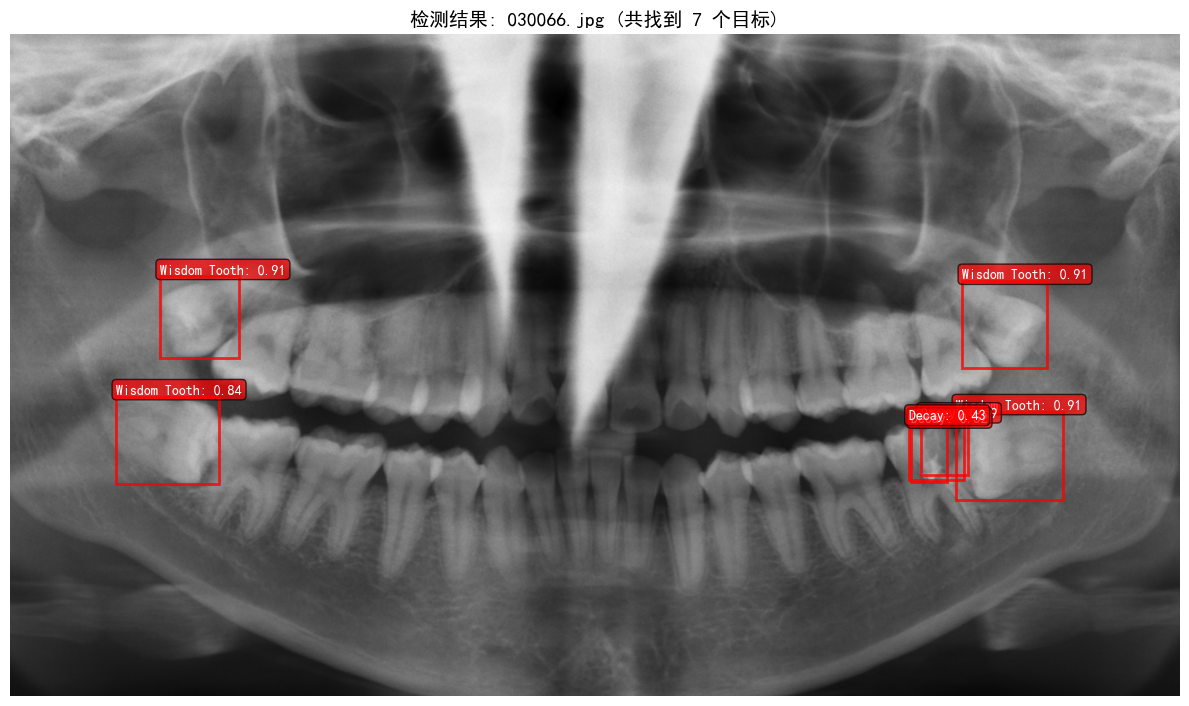

检测完成，共发现 7 个目标


In [16]:
# DentalAI Detection Demo - 任意图像检测

from utils.demo_utils import DentalDetectionDemo
import os

# 模型文件路径【手动输入】
model_path = r"outputs\oralxrays9\train_yolov8m_1ep_2025_08_17_21_25_02\weights\best.pt"
# 测试图片路径【手动输入】
image_path = r"preprocessed_datasets\oralxrays9\test\images\030066.jpg"

# 模型文件路径格式: outputs/{dataset_name}/train_xxx/weights/best.pt
# 对应的data_yaml: preprocessed_datasets/{dataset_name}/data.yaml
path_parts = model_path.replace('\\', '/').split('/')
dataset_name = path_parts[1]
data_yaml = f"preprocessed_datasets/{dataset_name}/data.yaml"

print(f"模型文件路径: {model_path}")
print(f"配置文件路径: {data_yaml}")
print(f"测试图像路径: {image_path}")

# 检查文件存在性
if not os.path.exists(model_path):
    print(f"错误: 模型文件不存在")
    raise FileNotFoundError(f"模型文件不存在: {model_path}")
elif not os.path.exists(data_yaml):
    print(f"错误: 配置文件不存在")
    raise FileNotFoundError(f"配置文件不存在: {data_yaml}")
elif not os.path.exists(image_path):
    print(f"错误: 测试图像不存在")
    raise FileNotFoundError(f"测试图像不存在: {image_path}")
else:
    print("所有文件存在，准备开始检测！")

# 创建演示对象
demo = DentalDetectionDemo(model_path, data_yaml)

# 运行检测（仅预测，无真实标签对比）
result = demo.predict_only(image_path, conf_threshold=0.3)

print(f"检测完成，共发现 {result['prediction_count']} 个目标")